In [1]:
from qiskit import pulse, circuit, transpile, assemble, schedule, IBMQ, QuantumCircuit, quantum_info as qi 
import qiskit
from qiskit.visualization import plot_gate_map, plot_error_map
from qiskit.visualization.pulse_v2 import draw
from qiskit.pulse import ShiftPhase, GaussianSquare, Drag, ControlChannel, MeasureChannel, DriveChannel, Play, Schedule
import numpy as np
from qiskit.tools import job_monitor
from copy import deepcopy
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [64]:
account_provider = IBMQ.load_account()
provider_opts = {'hub': 'ibm-q-ncsu', 'group': 'nc-state', 'project':'noiseanderror'}

# target backend
backend_name = 'ibmq_jakarta'

provider = IBMQ.get_provider(**provider_opts)
backend = provider.get_backend(backend_name)

# backend information
config = backend.configuration()
defaults = backend.defaults()
properties = backend.properties()

# instruction schedule map
inst_map = defaults.instruction_schedule_map

ibmqfactory.load_account:WARNING:2021-12-01 14:15:09,878: Credentials are already in use. The existing account in the session will be replaced.


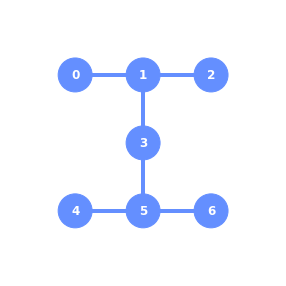

In [3]:
qubits = plot_gate_map(backend)
qubits

In [4]:
def extract_cr_params(cx_sched):
    cr_params = {}
    for time, inst in cx_sched.instructions:
        if isinstance(inst, Play):
            if isinstance(inst.pulse, GaussianSquare):
                if isinstance(inst.operands[1], ControlChannel):
                    cr_params["duration"] = inst.pulse.duration
                    cr_params["width"] = inst.pulse.width
                    cr_params["sigma"] = inst.pulse.sigma
                    cr_params["cr_amp"] = inst.pulse.amp
                    cr_params["channel"] = inst.channel
    return cr_params
                    

def build_cr_schedule(backend, qc, qt, cr_params, cr_name):
    
    with pulse.build(backend=backend, default_alignment="left", name="cr_schedule") as cross_resonance:
        pulse.play(GaussianSquare(
            duration=cr_params["duration"],
            amp=cr_params["cr_amp"],
            width=cr_params["width"],
            sigma=cr_params["sigma"],
            name=cr_name
        ),
        pulse.control_channels(qc, qt)[0],
    )
        if not np.isclose(cr_params["cancel_amp"], 0.0):
            pulse.play(GaussianSquare(
                duration=cr_params["duration"],
                amp=cr_params["cancel_amp"],
                width=cr_params["width"],
                sigma=cr_params["sigma"],
        ),
        pulse.drive_channel(qt),
    )
        else:
            pulse.delay(cr_params["duration"], pulse.drive_channel(qt))
        pulse.delay(cr_params["duration"], pulse.drive_channel(qc))
        
    return cross_resonance

def build_cr_circuit(gate):
    
    cr_circuit = QuantumCircuit(2)
    cr_circuit.append(gate, [0, 1])

    
    return cr_circuit

def build_amp_experiment_circuits(backend, qc, qt, amps, cr_params, rotary=False):
    
    circ_list = []
    
    inst_map_list = []
    for amplitude in amps:
        
        new_inst_map = deepcopy(inst_map)
    

        cr_p_gate = circuit.Gate(
            "cr_p_gate",
            num_qubits=2,
            params=[amplitude],
        )
        
        
        cr_m_gate = circuit.Gate(
            "cr_m_gate",
            num_qubits=2,
            params=[-amplitude],
        )
        
        exp_circ = QuantumCircuit(2)

        ## add control state prep when needed
        
        
        exp_circ.rz(-np.pi/2, 0)
        exp_circ.x(0)
        exp_circ.compose(other=build_cr_circuit(cr_p_gate), qubits=[0, 1], inplace=True)
        exp_circ.x(0)
        exp_circ.compose(other=build_cr_circuit(cr_m_gate), qubits=[0, 1], inplace=True)
#         exp_circ.x(0)
        
        exp_circ.metadata={
            "qubits": (qc, qt)
        }

        if rotary is True:
            cr_params['cancel_amp'] = amplitude
            
        cr_params["phi"] = 0
        cr_params['cr_amp'] = amplitude * np.exp(-1j*cr_params["phi"])
#         print(cr_params["cr_amp"], cr_params['phi'])
        exp_circ.add_calibration(gate=cr_p_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_p"))
        
        cr_params['phi'] = cr_params['phi'] + np.pi
        cr_params['cr_amp'] = amplitude * np.exp(-1j*cr_params["phi"])
#         print(cr_params["cr_amp"], cr_params['phi'])
        exp_circ.add_calibration(gate=cr_m_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_m"))
        exp_circ.measure_active()
        
#         new_inst_map.add('cr_gate', qubits=[qc, qt], schedule=build_cr_schedule(backend, qc, qt, cr_params))
        
        circ_list.append(exp_circ)
        inst_map_list.append(new_inst_map)
    return circ_list, inst_map_list

def build_phase_experiment_circuits(backend, qc, qt, phases, cr_params, rotary=False):
    
    circ_list = []
    inst_map_list = []
    amp = cr_params['cr_amp']
    for phase in phases:
        new_inst_map = deepcopy(inst_map)
    
        cr_p_gate = circuit.Gate(
            "cr_p_gate",
            num_qubits=2,
            params=[phase],
        )
        
        cr_m_gate = circuit.Gate(
            "cr_m_gate",
            num_qubits=2,
            params=[phase],
        )
        exp_circ = QuantumCircuit(2)
        exp_circ.rz(-np.pi/2, 0)
        exp_circ.x(0)
        exp_circ.compose(other=build_cr_circuit(cr_p_gate), qubits=[0, 1], inplace=True)
        exp_circ.x(0)
        exp_circ.compose(other=build_cr_circuit(cr_m_gate), qubits=[0, 1], inplace=True)
        exp_circ.barrier(0, 1)
        exp_circ.sdg(1)
        exp_circ.h(1)
        
        
        exp_circ.metadata={
            "qubits": (qc, qt)
        }
        
        if rotary is True:
            cr_params['cancel_amp'] = cr_params["cr_amp"]
        
        cr_params['cr_amp'] = amp * np.exp(-1j*phase)
#         print(cr_params['cr_amp'])
        exp_circ.add_calibration(gate=cr_p_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_p"))

        phase = phase + np.pi
        cr_params['cr_amp'] = amp * np.exp(-1j*phase)
#         print(cr_params['cr_amp'])
        exp_circ.add_calibration(gate=cr_m_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_m"))
        exp_circ.measure_active()
        
        circ_list.append(exp_circ)
        inst_map_list.append(new_inst_map)
        
    return circ_list, inst_map_list

def build_single_cr_circuit(backend, qc, qt, cr_params, rotary=False):
    amp = cr_params['cr_amp']
    cr_p_gate = circuit.Gate(
            "cr_p_gate",
            num_qubits=2,
            params=[cr_params["cr_amp"], cr_params["phase"]],
        )
        
    cr_m_gate = circuit.Gate(
            "cr_m_gate",
            num_qubits=2,
            params=[cr_params["cr_amp"], cr_params["phase"]],
        )
    exp_circ = QuantumCircuit(2)

        
    exp_circ.rz(-np.pi/2, 0)
    exp_circ.x(0)
    exp_circ.compose(other=build_cr_circuit(cr_p_gate), qubits=[0, 1], inplace=True)
    exp_circ.x(0)
    exp_circ.compose(other=build_cr_circuit(cr_m_gate), qubits=[0, 1], inplace=True)
    
    exp_circ.metadata={
        "qubits": (qc, qt)
    }

    if rotary is True:
        cr_params['cancel_amp'] = amplitude
        
    cr_params['cr_amp'] = amp * np.exp(-1j*cr_params["phase"])
    exp_circ.add_calibration(gate=cr_p_gate,
                            qubits=[qc,qt],
                            schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_p"))

    cr_params['cr_amp'] = amp * np.exp(-1j*(cr_params["phase"]+np.pi))
    exp_circ.add_calibration(gate=cr_m_gate,
                            qubits=[qc,qt],
                            schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_m"))  
    
    return exp_circ
    
        
def expectation_val(count_dict, mem_ind):

    expv = 0
    for key, val in count_dict.items():
        if key[::-1][mem_ind] == '1':
#             print(key, val)
            expv -= val
        else:
            expv += val
#     print(expv)
    return expv / sum(count_dict.values())

In [5]:
q1, q2 = 0, 1
mem_ind = 0 if q1 > q2 else 1

# IBM's cross resonance gate
This is what IBM's cross-resonance gate looks like - extracted from the CX pulse schedule, and with the rotary tones not shown.

In [6]:
cx_sched = inst_map.get('cx', qubits=[q1, q2])
cx_sched_fig = draw(cx_sched, backend=backend)
cx_sched_fig.savefig("ibm_cx")

In [7]:
insts = []
for time, inst in cx_sched.instructions:
    print(inst)
    if isinstance(inst, ShiftPhase):
        insts.append(inst)
        continue
    if isinstance(inst.pulse, Drag):
        if inst.channel == DriveChannel(1):
            continue
    insts.append((time,inst))

ShiftPhase(1.5707963267948966, DriveChannel(0))
ShiftPhase(1.5707963267948966, ControlChannel(1))
Play(Drag(duration=160, amp=(-3.647066355955947e-17-0.19853704532034197j), sigma=40, beta=-0.9740804109491876, name='Ym_d0'), DriveChannel(0), name='Ym_d0')
Play(Drag(duration=160, amp=(0.09608240812566482+0.0019772615602782627j), sigma=40, beta=-1.0576421988625249, name='X90p_d1'), DriveChannel(1), name='X90p_d1')
Play(GaussianSquare(duration=368, amp=(0.11222816406675254+0.002379409800750389j), sigma=64, width=112, name='CR90p_d1_u0'), DriveChannel(1), name='CR90p_d1_u0')
Play(GaussianSquare(duration=368, amp=(-0.007286752801461287-0.7569497016553327j), sigma=64, width=112, name='CR90p_u0'), ControlChannel(0), name='CR90p_u0')
Play(Drag(duration=160, amp=(0.19853704532034197+0j), sigma=40, beta=-0.9740804109491876, name='Xp_d0'), DriveChannel(0), name='Xp_d0')
Play(GaussianSquare(duration=368, amp=(-0.11222816406675254-0.002379409800750375j), sigma=64, width=112, name='CR90m_d1_u0'), Dri

In [8]:
ibm_cr_sched = Schedule()
for inst in insts:
    if isinstance(inst, ShiftPhase):
        ibm_cr_sched.insert(0, inst, inplace=True)
        continue
#     print(inst)
    ibm_cr_sched.insert(inst[0], inst[1], inplace=True)
        

In [9]:
ibm_cr_fig = draw(ibm_cr_sched, backend=backend)
ibm_cr_fig.savefig("ibm_cr_sched")

In [10]:
cr_params = extract_cr_params(cx_sched)
cr_params["cancel_amp"] = 0.0
cr_params["phi"] = 0
# print(cr_params)

max_cr_amplitude = 1.0
num_amps = 70
cr_amps = np.linspace(-max_cr_amplitude, max_cr_amplitude, num_amps)
# print(cr_amps)

In [11]:
exp_circuits, exp_inst_maps = build_amp_experiment_circuits(backend, q1, q2, cr_amps, cr_params)
# exp_circuits[19].draw()

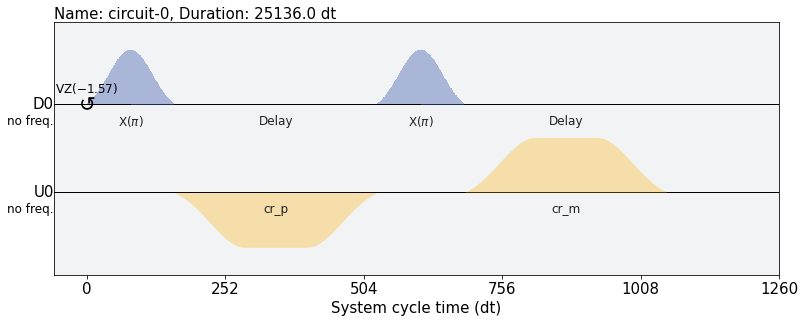

In [12]:
tc = transpile(exp_circuits, backend, initial_layout=[q1, q2])
sched = schedule(tc, backend)
# for time, inst in sched[4].instructions:
#     print(inst)
sched[0].draw(time_range=[0, 1200], disable_channels=[MeasureChannel(q1), MeasureChannel(q2)])

In [14]:
# tc[0].draw('mpl')

In [15]:
# draw(sched[4], backend=backend, time_range=[0, 1000], disable_channels=[MeasureChannel(q1), MeasureChannel(q2)])

In [13]:
i = 1
identifier = F"(({max_cr_amplitude}),{num_amps})"

In [14]:
job = backend.run(tc, job_name=F"cr_amp_exp_{identifier}", shots=2048)
job_id = job.job_id()
print(job.job_id())

61a7af64fd929e5d62d188c1


In [15]:
# 11/8/2021 - amplitude experiments
# ibm_lagos job (9:45~ am) - 6189380f1452777724117b88
# ibmq_jakarta job (10:00~ am) - 61893b88902694642fd98881
# ibmq_jakarta (10:30~ am) - 6189411bc45f2664c31517c5
# ibmq_jakarta (10:51~ am) - 61894761ad7fa029bcd1440f * best results so far (sweeping from (-1.0, 1.0, 70))
# ibmq_jakarta (11:23~ am) - 61894f14ad7fa0ed2ad14439
# ibmq_jakarta (12:47 pm) - 618962b8ce94116c106c071e (-1.0, 1.0, 70) - CRgate looks more like ibm
# ibmq_montreal (11:18~ am) - 61894de8c45f2661c61517fb
# ibmq_toronto (11:27~ am) - 61894fdab3f4906ac760bf9e
# ibmq_toronto (11:33~ am) - 61895180145277452e117c10

# 11/9/2021 - amplitude experiments
# ibmq_jakarta (10:33~ am) - 618a94942bf2b36efea11649 (-1.0, 1.0, 70)

#11/20/2021 - AMPL
#IBMQ_JAKARTA (9:12~ AM) - 61990220580e751b2414e77e
# jakarta - 61996d7e1db79fb3a6da3065

# 11/10/2021 - amplitude experiments
# jakarta (12:40~ pm) - 618c03d7513c76539a62fee6
# job_id = "618962b8ce94116c106c071e"

# 12/1/2021
# jakarta 61a7af64fd929e5d62d188c1
results = backend.retrieve_job(job_id).result()


In [16]:
count_dict = results.get_counts()
print(count_dict)

[{'00': 828, '01': 18, '10': 1187, '11': 15}, {'00': 776, '01': 11, '10': 1244, '11': 17}, {'00': 782, '01': 15, '10': 1230, '11': 21}, {'00': 839, '01': 14, '10': 1188, '11': 7}, {'00': 863, '01': 27, '10': 1140, '11': 18}, {'00': 943, '01': 20, '10': 1078, '11': 7}, {'00': 950, '01': 17, '10': 1074, '11': 7}, {'00': 989, '01': 13, '10': 1035, '11': 11}, {'00': 1000, '01': 24, '10': 1012, '11': 12}, {'00': 1101, '01': 20, '10': 915, '11': 12}, {'00': 1097, '01': 18, '10': 919, '11': 14}, {'00': 1174, '01': 19, '10': 838, '11': 17}, {'00': 1141, '01': 17, '10': 878, '11': 12}, {'00': 1212, '01': 8, '10': 821, '11': 7}, {'00': 1265, '01': 22, '10': 749, '11': 12}, {'00': 1308, '01': 29, '10': 704, '11': 7}, {'00': 1387, '01': 22, '10': 630, '11': 9}, {'00': 1419, '01': 15, '10': 611, '11': 3}, {'00': 1444, '01': 27, '10': 573, '11': 4}, {'00': 1500, '01': 23, '10': 520, '11': 5}, {'00': 1557, '01': 22, '10': 460, '11': 9}, {'00': 1607, '01': 17, '10': 418, '11': 6}, {'00': 1628, '01': 2

# The following two snippets of code to fit the amplitude curves were copied from the work "Qiskit Pulse: Programming Quantum Computers through the Cloud with Pulse"
https://arxiv.org/pdf/2004.06755.pdf

In [17]:
def cr_fit_3rd_order_perturbation(x, c1, c2):
    fx = c1*x - c2*x**3
    return np.cos(2 * np.pi * fx)

def rough_amp_objective(x, params, opt_phase):
    fx = params[0] * x - params[1] * x**3
    return np.abs(opt_phase / 2 / np.pi - fx)

In [18]:
exp_z = np.zeros_like(cr_amps)
for cind in range(len(cr_amps)):
    exp_z[cind] = expectation_val(count_dict[cind], mem_ind=mem_ind)
# print(exp_z)
valid_inds = np.where(np.abs(cr_amps) < 1.0)[0]
params, _ = opt.curve_fit(cr_fit_3rd_order_perturbation, xdata=cr_amps[valid_inds], ydata=exp_z[valid_inds])
cr_pi2_amp = opt.minimize(rough_amp_objective, x0=0, bounds=[(0, 1)], args=(params, 0.5 * np.pi)).x[0]

In [19]:
print(cr_pi2_amp)

0.768046826387235


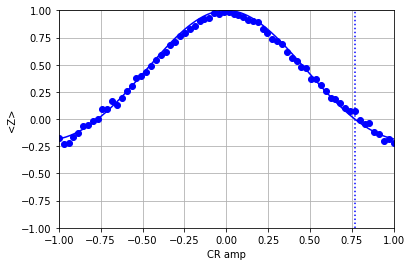

In [31]:
x_interp = np.linspace(cr_amps[0], cr_amps[-1], 1000)
plt.plot(cr_amps, exp_z, 'o', color='b')
plt.plot(x_interp, cr_fit_3rd_order_perturbation(x_interp, *params), color='b')
plt.plot([cr_pi2_amp, cr_pi2_amp], [-1, 1], 'b:')
plt.xlim(-max_cr_amplitude, max_cr_amplitude)
plt.ylim(-1, 1)
plt.xlabel('CR amp')
plt.ylabel('<Z>')
plt.grid()
plt.savefig("12_1_CR_jakarta_amplitude_calibration")

In [21]:
cr_params = extract_cr_params(cx_sched)
cr_params["cr_amp"] = cr_pi2_amp
cr_params["cancel_amp"] = 0.0

max_phase = np.pi
num_phases = 20
cr_phases = np.linspace(-max_phase, max_phase, num_phases)


In [33]:
# for phase in cr_phases:
#     print(cr_pi2_amp * np.exp(-1j*phase))
#     print(cr_pi2_amp * np.exp(-1j*(phase+np.pi)))

In [24]:
print(cr_params)

{'duration': 368, 'width': 112, 'sigma': 64, 'cr_amp': 0.768046826387235, 'channel': ControlChannel(0), 'cancel_amp': 0.0}


In [25]:
phase_exp_circuits, phase_exp_inst_maps = build_phase_experiment_circuits(backend, q1, q2, cr_phases, cr_params)


In [26]:
y0 = deepcopy(phase_exp_circuits)
y1 = []
for circ in y0:
    y1_circ = QuantumCircuit(2)
    y1_circ.x(0)
    y1_circ += circ
    y1.append(y1_circ)

<ipython-input-26-95e79d3478e8>:6: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  y1_circ += circ
C:\Users\Zachary\anaconda3\envs\NewestPythonQiskit\lib\site-packages\qiskit\circuit\quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


In [27]:
phase_exp_circuits = y0+y1
tc = transpile(phase_exp_circuits, backend, initial_layout=[q1, q2])
identifier = F"(({max_phase}),{num_phases})"

In [30]:
job = backend.run(tc, job_name=F"cr_amp_exp_{identifier}", shots=2048)
job_id = job.job_id()
print(job.job_id())

61a7ba1ed28a8880cc8d04a0


In [34]:
# 11/9/2021 - phase experiments
# ibmq_jakarta (11:27~ am) - 618aa15deb641130bbbb5c4f (-np.pi, np.pi, 20)

# 11/10/2021 - phase experiments
# jakarta (12:42~ pm) - 618c047e513c768d4d62feee (-np.pi, np.pi, 20) 
# job_id = "618c047e513c768d4d62feee"

# 11/20/2021 - phase experiments
# jakarta (9:52 am) - 61990bb053ac6c1ad1d58d49
# jakarata - 61996ddd580e7570ed14e9d4

# 12/1/2021 - phase
# jakarta - 61a7ba1ed28a8880cc8d04a0
results = backend.retrieve_job(job_id).result()
print(job_id)

61a7ba1ed28a8880cc8d04a0


In [35]:
count_dict = results.get_counts()
print(count_dict)

[{'00': 1003, '01': 12, '10': 1018, '11': 15}, {'00': 720, '01': 8, '10': 1300, '11': 20}, {'00': 455, '01': 13, '10': 1563, '11': 17}, {'00': 244, '01': 11, '10': 1777, '11': 16}, {'00': 100, '01': 7, '10': 1922, '11': 19}, {'00': 83, '01': 11, '10': 1935, '11': 19}, {'00': 131, '01': 10, '10': 1892, '11': 15}, {'00': 244, '01': 11, '10': 1770, '11': 23}, {'00': 512, '01': 10, '10': 1509, '11': 17}, {'00': 727, '01': 13, '10': 1295, '11': 13}, {'00': 1023, '01': 19, '10': 991, '11': 15}, {'00': 1365, '01': 11, '10': 660, '11': 12}, {'00': 1675, '01': 20, '10': 346, '11': 7}, {'00': 1886, '01': 23, '10': 128, '11': 11}, {'00': 1987, '01': 17, '10': 28, '11': 16}, {'00': 1966, '01': 18, '10': 53, '11': 11}, {'00': 1845, '01': 15, '10': 170, '11': 18}, {'00': 1592, '01': 23, '10': 420, '11': 13}, {'00': 1361, '01': 13, '10': 649, '11': 25}, {'00': 956, '01': 16, '10': 1056, '11': 20}, {'00': 40, '01': 846, '10': 33, '11': 1129}, {'00': 44, '01': 1166, '10': 42, '11': 796}, {'00': 46, '01

In [36]:
print(len(count_dict))

40


# The next few snippets here (regarding data fitting) were also copied from the Thomas Alexander work

In [37]:
def cos_fit_00(x, a, b):
    return a * np.cos(x - b + np.pi)

def cos_fit_10(x, a, b):
    return a * np.cos(x - b)

In [38]:
exp_y0 = np.zeros_like(cr_phases)
exp_y1 = np.zeros_like(cr_phases)

results_y0 = count_dict[:20]
results_y1 = count_dict[20:]

for cind in range(len(cr_phases)):
    exp_y0[cind] = expectation_val(results_y0[cind], mem_ind=mem_ind)
    exp_y1[cind] = expectation_val(results_y1[cind], mem_ind=mem_ind)
# print(exp_y0)
# print(exp_y1)

params0, _ = opt.curve_fit(cos_fit_00, xdata=cr_phases, ydata=exp_y0, bounds=([0, -np.pi], [1, np.pi]))
params1, _ = opt.curve_fit(cos_fit_10, xdata=cr_phases, ydata=exp_y1, bounds=([0, -np.pi], [1, np.pi]))

phi_opt = (params0[1] + params1[1]) / 2
print(phi_opt)

-1.4966682333518144


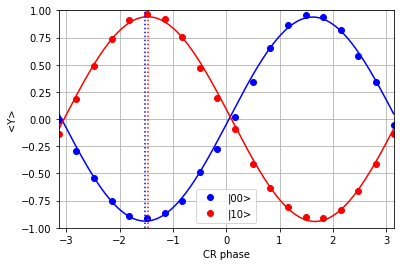

In [61]:
x_interp = np.linspace(cr_phases[0], cr_phases[-1], 1000)
plt.plot(cr_phases, exp_y0, 'o', color='b', label='|00>')
plt.plot(cr_phases, exp_y1, 'o', color='r', label='|10>')
plt.plot(x_interp, cos_fit_00(x_interp, *params0), 'b')
plt.plot(x_interp, cos_fit_10(x_interp, *params1), 'r')
plt.plot([params0[1], params0[1]], [-1, 1], 'b:')
plt.plot([params1[1], params1[1]], [-1, 1], 'r:')
plt.xlim(cr_phases[0], cr_phases[-1])
plt.ylim(-1, 1)
plt.xlabel('CR phase')
plt.ylabel('<Y>')
plt.grid()
plt.legend()
plt.savefig("12_1_jakarta_final_phase_calibration_2")

In [43]:
cr_params = extract_cr_params(cx_sched)
cr_params["cr_amp"] = cr_pi2_amp
cr_params["cancel_amp"] = 0.0
cr_params["phase"] = phi_opt

In [81]:
print(cr_params)

{'duration': 368, 'width': 112, 'sigma': 64, 'cr_amp': (-0.0568817195687381-0.7659375937388156j), 'channel': ControlChannel(0), 'cancel_amp': 0.0, 'phase': -1.4966682333518144}


In [88]:
with pulse.build(backend=backend, default_alignment="left", name="cr_schedule") as cross_resonance:
    pulse.play(GaussianSquare(
        duration=cr_params["duration"],
        amp=-cr_params["cr_amp"],
        width=cr_params["width"],
        sigma=cr_params["sigma"],
        name="CR"
    ),
    pulse.control_channels(0, 1)[0],
)
cr_ex_sched = draw(cross_resonance, backend=backend)
cr_ex_sched.savefig("example_gaussian_square", bbox_inches='tight')

In [44]:
print(cr_pi2_amp*np.exp(-1j*phi_opt))

(0.0568817195687382+0.7659375937388156j)


In [45]:
cr_circ = build_single_cr_circuit(backend, q1, q2, cr_params, rotary=False)

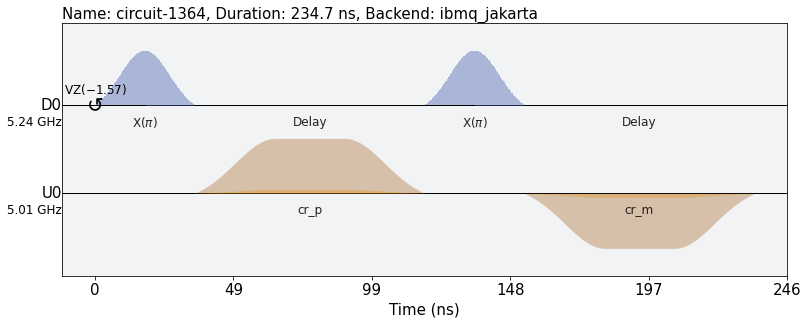

In [46]:
tc_cr_circ = transpile(cr_circ, backend, initial_layout=[0, 1])
my_cr_sched = schedule(cr_circ, backend)
cr_fig = draw(my_cr_sched, backend=backend)
# cr_fig.savefig("custom_cr")
cr_fig

In [47]:
my_cnot_circ = QuantumCircuit(2)
my_cnot_circ.x(0)
my_cnot_circ.x(1)
my_cnot_circ.compose(other=cr_circ, qubits=[0, 1], inplace=True)
my_cnot_circ.measure_active()

In [48]:
default_cnot = QuantumCircuit(2)
default_cnot.x(0)
default_cnot.cx(0, 1)
default_cnot.measure_active()

In [77]:
my_cnot_circ.draw('mpl').savefig("custom_x_cnot_circuit")

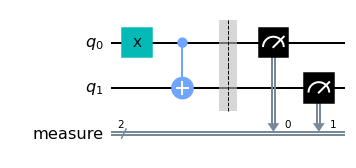

In [50]:
fig = default_cnot.draw('mpl')
# fig.savefig("x_cnot_circuit")
fig

In [51]:
my_tc = transpile(my_cnot_circ, backend, initial_layout=[q1, q2])
default_tc = transpile(default_cnot, backend, initial_layout=[q1, q2])

circs = [my_tc]+[default_tc]


In [54]:
job = backend.run(circs, job_name=F"cnot_exp", shots=2048)
job_id = job.job_id()
print(job.job_id())

61a7be99313f8111c6c3bcb9


In [55]:
# 11/10/2021 cnot experiments
# jakarta (2:22~pm) - 618c1bb1513c764b2962ffaf --- messed up
# jakarta (2:51~pm) - 618c22d248856aacecedacb9 - ehhh
# jakarta (2:56~pm) - 618c23c83b109c3a24477641 -- messed up
# jakarta (3:04~pm) - 618c25b98b10e7814568d1c6 

# 11/20/2021
# Jakarta - 61996f0c9920cdc37794be1a

# 12/1/2021
# jakarta - 61a7be99313f8111c6c3bcb9
results = backend.retrieve_job(job_id).result()
print(job_id)

61a7be99313f8111c6c3bcb9


In [56]:
counts = results.get_counts()
print(counts)

[{'00': 39, '01': 899, '10': 54, '11': 1056}, {'00': 21, '01': 74, '10': 59, '11': 1894}]


In [59]:
from qiskit.visualization import plot_histogram
plot_histogram(counts[0]).savefig("12_1_custom_cnot_simple")

In [60]:
plot_histogram(counts[1]).savefig("12_1_default_cnot_simple")

# QPT

In [65]:
import qiskit.ignis.verification.tomography
from qiskit import QuantumRegister
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter


qpt_circs = process_tomography_circuits(cr_circ, [q1, q2])

In [66]:
job = qiskit.execute(qpt_circs, backend, shots=2000)
job_id = job.job_id()
print(job.job_id())

61a7c9c8d28a88f2d28d04eb


In [ ]:
# qpt experiments
# jakarta - 61990d8c8982d9d954338306
# jakarta - 61997009cd37f3855df268fc

# 12/1/2021
# jakarta 61a7c9c8d28a88f2d28d04eb

In [67]:
qpt_tomo = ProcessTomographyFitter(job.result(), qpt_circs)
qpt_tomo.data

{(('Zp', 'Zp'), ('X', 'X')): {'00': 537, '01': 493, '10': 487, '11': 483},
 (('Zp', 'Zp'), ('X', 'Y')): {'00': 37, '01': 48, '10': 970, '11': 945},
 (('Zp', 'Zp'), ('X', 'Z')): {'00': 455, '01': 452, '10': 526, '11': 567},
 (('Zp', 'Zp'), ('Y', 'X')): {'00': 533, '01': 463, '10': 496, '11': 508},
 (('Zp', 'Zp'), ('Y', 'Y')): {'00': 39, '01': 28, '10': 942, '11': 991},
 (('Zp', 'Zp'), ('Y', 'Z')): {'00': 476, '01': 451, '10': 509, '11': 564},
 (('Zp', 'Zp'), ('Z', 'X')): {'00': 1030, '01': 8, '10': 943, '11': 19},
 (('Zp', 'Zp'), ('Z', 'Y')): {'00': 55, '01': 11, '10': 1913, '11': 21},
 (('Zp', 'Zp'), ('Z', 'Z')): {'00': 920, '01': 10, '10': 1055, '11': 15},
 (('Zp', 'Zm'), ('X', 'X')): {'00': 509, '01': 494, '10': 499, '11': 498},
 (('Zp', 'Zm'), ('X', 'Y')): {'00': 990, '01': 958, '10': 18, '11': 34},
 (('Zp', 'Zm'), ('X', 'Z')): {'00': 546, '01': 565, '10': 490, '11': 399},
 (('Zp', 'Zm'), ('Y', 'X')): {'00': 566, '01': 467, '10': 454, '11': 513},
 (('Zp', 'Zm'), ('Y', 'Y')): {'00': 

In [80]:
import time
from qiskit.quantum_info.operators import Operator, Pauli
# default_cx = QuantumCircuit(2)
# default_cx.cx(0,1)
# target_unitary = qi.Operator(default_cx)
# print(target_unitary)
ZX = Pauli(label="ZX")
target_unitary = Operator(ZX)
t = time.time()
choi_fit = qpt_tomo.fit(method='lstsq')
print('Fit time:', time.time() - t)
print('Average gate fidelity: F = {:.5f}'.format(qi.average_gate_fidelity(choi_fit, target=target_unitary)))

Fit time: 0.22299814224243164
Average gate fidelity: F = 0.20224


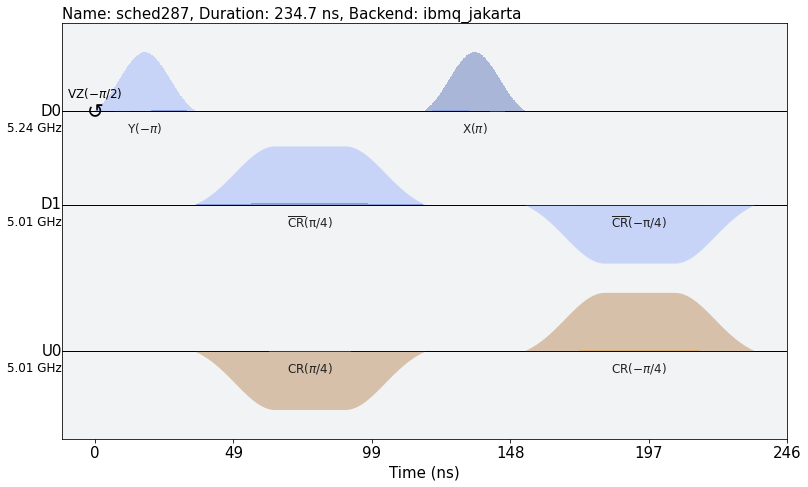

In [69]:
draw(ibm_cr_sched, backend=backend)

In [70]:
cr_gate = circuit.Gate("cr", num_qubits=2, params=[])
qc = QuantumCircuit(2)
qc.append(cr_gate, [q1, q2])
qc.add_calibration(cr_gate, (q1, q2), ibm_cr_sched)


In [71]:
qpt_circs = process_tomography_circuits(qc, [q1, q2])

In [72]:
job = qiskit.execute(qpt_circs, backend, shots=2000)
job_id = job.job_id()
print(job.job_id())

61a7caad6a8ec02080198d89


In [73]:
# qpt on default IBM CR - jakarta
# 61a7caad6a8ec02080198d89
qpt_tomo = ProcessTomographyFitter(job.result(), qpt_circs)
qpt_tomo.data

{(('Zp', 'Zp'), ('X', 'X')): {'00': 565, '01': 454, '10': 516, '11': 465},
 (('Zp', 'Zp'), ('X', 'Y')): {'00': 1008, '01': 965, '10': 13, '11': 14},
 (('Zp', 'Zp'), ('X', 'Z')): {'00': 511, '01': 580, '10': 488, '11': 421},
 (('Zp', 'Zp'), ('Y', 'X')): {'00': 543, '01': 467, '10': 487, '11': 503},
 (('Zp', 'Zp'), ('Y', 'Y')): {'00': 988, '01': 978, '10': 13, '11': 21},
 (('Zp', 'Zp'), ('Y', 'Z')): {'00': 561, '01': 547, '10': 451, '11': 441},
 (('Zp', 'Zp'), ('Z', 'X')): {'00': 998, '01': 16, '10': 973, '11': 13},
 (('Zp', 'Zp'), ('Z', 'Y')): {'00': 1936, '01': 29, '10': 30, '11': 5},
 (('Zp', 'Zp'), ('Z', 'Z')): {'00': 1048, '01': 19, '10': 923, '11': 10},
 (('Zp', 'Zm'), ('X', 'X')): {'00': 535, '01': 507, '10': 503, '11': 455},
 (('Zp', 'Zm'), ('X', 'Y')): {'00': 40, '01': 34, '10': 982, '11': 944},
 (('Zp', 'Zm'), ('X', 'Z')): {'00': 496, '01': 432, '10': 512, '11': 560},
 (('Zp', 'Zm'), ('Y', 'X')): {'00': 550, '01': 522, '10': 470, '11': 458},
 (('Zp', 'Zm'), ('Y', 'Y')): {'00': 

In [75]:
import time
t = time.time()
choi_fit = qpt_tomo.fit(method='lstsq')
print('Fit time:', time.time() - t)
print('Average gate fidelity: F = {:.5f}'.format(qi.average_gate_fidelity(choi_fit)))

Fit time: 0.22500014305114746
Average gate fidelity: F = 0.40146
